In [1]:
import numpy as np
from aisynphys.database import default_db as db
from aisynphys.cell_class import CellClass

In [2]:
cell_class_criteria = {
    'l23pyr': {'dendrite_type': 'spiny', 'target_layer': '2/3'},
    'l4pyr':  {'cre_type': 'nr5a1'},
    'l5et':   {'cre_type': ('sim1', 'fam84b')},
    'l5it':   {'cre_type': 'tlx3'}, 
    'l6pyr':  {'cre_type': 'ntsr1'},
    'pv':     {'cre_type': 'pvalb'},
    'sst':    {'cre_type': 'sst'},
    'vip':    {'cre_type': 'vip'},  
}

cell_classes = {name:CellClass(name=name, **criteria) for name,criteria in cell_class_criteria.items()}

In [3]:
from collections import OrderedDict

results = OrderedDict()
pairs = None
for pre_name, pre_class in cell_classes.items():
    for post_name, post_class in cell_classes.items():
        pair_query = db.pair_query(
            project_name=["mouse V1 coarse matrix", 'mouse V1 pre-production'],
            pre_class=pre_class,
            post_class=post_class,
            synapse=True,
        )
        
        pair_query = pair_query.add_columns(
            db.Synapse.psp_amplitude,
            db.Synapse.psp_rise_time,
            db.Synapse.psp_decay_tau,
            db.Synapse.latency,
        )
        df = pair_query.dataframe()
        df['pre_class'] = pre_name
        df['post_class'] = post_name
        if pairs is None:
            pairs = df
        else:
            pairs = pairs.append(df)    

In [18]:
pairs_has_amp = pairs[~pairs['psp_amplitude'].isnull()]
psp_amp = pairs_has_amp.groupby(['pre_class', 'post_class']).aggregate(lambda x: np.mean(x))
psp_amp.head()

id  experiment_id   pre_cell_id  post_cell_id  \
pre_class post_class                                                            
l23pyr    l23pyr      42775.000000    1246.250000   7424.000000   7424.500000   
          l5et        80915.000000    2501.000000  14482.000000  14479.000000   
          pv          74118.916667    2273.416667  13179.583333  13177.333333   
          sst         79826.090909    2470.454545  14268.636364  14268.272727   
          vip         65999.888889    1981.000000  11617.222222  11617.222222   

                      has_synapse  has_electrical  crosstalk_artifact  \
pre_class post_class                                                    
l23pyr    l23pyr              1.0             0.0                 NaN   
          l5et                1.0             0.0                 NaN   
          pv                  1.0             0.0                 NaN   
          sst                 1.0             0.0                 NaN   
          vip                 1.0             0.0                 NaN   

                      n_ex_test_spikes  n_in_test_spikes  distance  meta  \
pre_class post_class                                                       
l23pyr    l23pyr            738.750000        398.750000  0.000070   NaN   
          l5et              533.000000        413.000000  0.000397   NaN   
          pv                681.583333        364.500000  0.000112   NaN   
          sst               598.636364        196.454545  0.000076   NaN   
          vip               652.555556        134.444444  0.000095   NaN   

                      psp_amplitude  psp_rise_time  psp_decay_tau   latency  
pre_class post_class                                                         
l23pyr    l23pyr           0.000185       0.004130       0.029526  0.001795  
          l5et            -0.000653       0.004891       0.011459  0.003594  
          pv               0.000316       0.002129       0.010590  0.001387  
          sst              0.000401       0.004388       0.049820  0.001527  
          vip              0.000523       0.005641       0.042133  0.001647

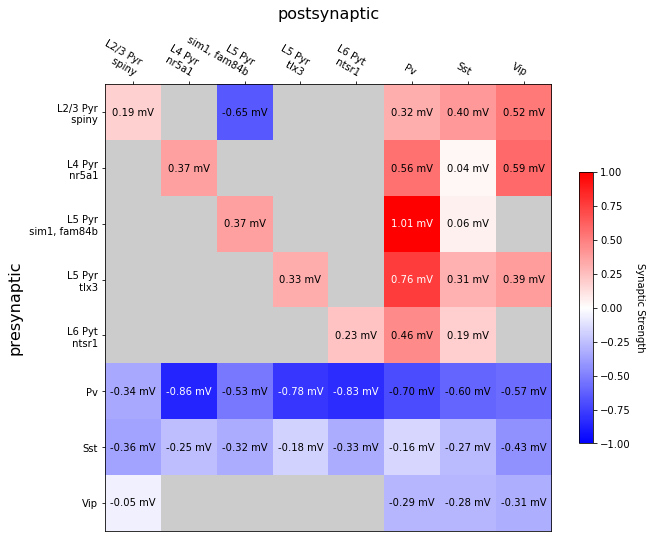

In [53]:
from aisynphys.ui.notebook import heatmap, annotate_heatmap
import matplotlib.colors, matplotlib.cm
import matplotlib.pyplot as plt
%matplotlib inline

cmap = matplotlib.cm.get_cmap('bwr')
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1, clip=False)

class_labels = {
    'l23pyr': 'L2/3 Pyr\n spiny',
    'l4pyr':  'L4 Pyr\n nr5a1',
    'l5et':   'L5 Pyr\n sim1, fam84b',
    'l5it':   'L5 Pyr\n tlx3', 
    'l6pyr':  'L6 Pyt\n ntsr1',
    'pv':     'Pv',
    'sst':    'Sst',
    'vip':    'Vip',
}

shape = (len(cell_classes), len(cell_classes))
data = np.zeros(shape)
data_alpha = np.zeros(shape)
data_str = np.zeros(shape, dtype=object)

for i, pre_class in enumerate(cell_classes):
    for j, post_class in enumerate(cell_classes):
        try:
            value = psp_amp.loc[pre_class].loc[post_class].psp_amplitude
        except KeyError:
            value = np.nan
        data[i, j] = value*1e3
        data_str[i, j] = "%0.2f mV" % (value*1e3) if np.isfinite(value) else ""
        data_alpha[i, j] = 1 if np.isfinite(value) else 0 
        
labels = [class_labels[cls] for cls in cell_classes]
mapper = matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm)
data_rgb = mapper.to_rgba(data)
data_rgb[:,:,3] = np.clip(data_alpha, 0, 1)

strength_fig, ax = plt.subplots(figsize=(10,10))
im, cbar = heatmap(data_rgb, labels, labels,
                  ax=ax,
                  ax_labels=('postsynaptic', 'presynaptic'),
                  bg_color=(0.8, 0.8, 0.8),
                  cmap=cmap,
                  norm=norm,
                  cbarlabel='Synaptic Strength',
                  cbar_kw={'shrink':0.5})

text = annotate_heatmap(im, data_str, data=data)

In [54]:
fname = 'C:\\Users\\stephanies\\aisynphys\\analyses\\figures\\Fig3A_strength_matrix.svg'
strength_fig.savefig(fname)

In [42]:
excitatory_labels = ['l23pyr', 'l4pyr', 'l5et', 'l5it', 'l6pyr']
inhibitory_labels = ['pv', 'sst', 'vip']

all_amps = pairs_has_amp['psp_amplitude']
ee_amps = pairs_has_amp[pairs_has_amp['pre_class'].isin(excitatory_labels) 
                            & pairs_has_amp['post_class'].isin(excitatory_labels)]['psp_amplitude']
ei_amps = pairs_has_amp[pairs_has_amp['pre_class'].isin(excitatory_labels) 
                            & pairs_has_amp['post_class'].isin(inhibitory_labels)]['psp_amplitude']
ie_amps = pairs_has_amp[pairs_has_amp['pre_class'].isin(inhibitory_labels) 
                            & pairs_has_amp['post_class'].isin(excitatory_labels)]['psp_amplitude']
ii_amps = pairs_has_amp[pairs_has_amp['pre_class'].isin(inhibitory_labels) 
                            & pairs_has_amp['post_class'].isin(inhibitory_labels)]['psp_amplitude']

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., 34., 19., 13.,  8.,  7.,  2.,  4.,  1.,  3.,  1.,  0.,
         0.,  0.,  0.,  0.]),
 array([-3.00000000e+00, -2.80000000e+00, -2.60000000e+00, -2.40000000e+00,
        -2.20000000e+00, -2.00000000e+00, -1.80000000e+00, -1.60000000e+00,
        -1.40000000e+00, -1.20000000e+00, -1.00000000e+00, -8.00000000e-01,
        -6.00000000e-01, -4.00000000e-01, -2.00000000e-01,  2.66453526e-15,
         2.00000000e-01,  4.00000000e-01,  6.00000000e-01,  8.00000000e-01,
         1.00000000e+00,  1.20000000e+00,  1.40000000e+00,  1.60000000e+00,
         1.80000000e+00,  2.00000000e+00,  2.20000000e+00,  2.40000000e+00,
         2.60000000e+00,  2.80000000e+00,  3.00000000e+00]),
 <a list of 30 Patch objects>)

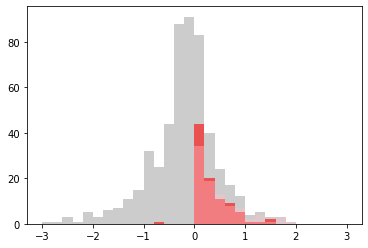

In [83]:
bin_edges = np.arange(-3, 3.1, 0.2)

hist1, ax = plt.subplots()
ax.hist(all_amps*1e3, bins=bin_edges, color=(0.8, 0.8, 0.8))

ax.hist(ee_amps*1e3, bins=bin_edges, color='red', alpha=0.6)
ax.hist(ei_amps*1e3, bins=bin_edges, color='pink', alpha=0.4)

In [62]:
fname = 'C:\\Users\\stephanies\\aisynphys\\analyses\\figures\\Fig3B_hist.svg'
hist1.savefig(fname)

(array([ 0.,  0.,  1.,  0.,  2.,  1.,  1.,  3.,  3.,  3.,  5.,  7., 18.,
        23., 22.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.]),
 array([-3.00000000e+00, -2.80000000e+00, -2.60000000e+00, -2.40000000e+00,
        -2.20000000e+00, -2.00000000e+00, -1.80000000e+00, -1.60000000e+00,
        -1.40000000e+00, -1.20000000e+00, -1.00000000e+00, -8.00000000e-01,
        -6.00000000e-01, -4.00000000e-01, -2.00000000e-01,  2.66453526e-15,
         2.00000000e-01,  4.00000000e-01,  6.00000000e-01,  8.00000000e-01,
         1.00000000e+00,  1.20000000e+00,  1.40000000e+00,  1.60000000e+00,
         1.80000000e+00,  2.00000000e+00,  2.20000000e+00,  2.40000000e+00,
         2.60000000e+00,  2.80000000e+00,  3.00000000e+00]),
 <a list of 30 Patch objects>)

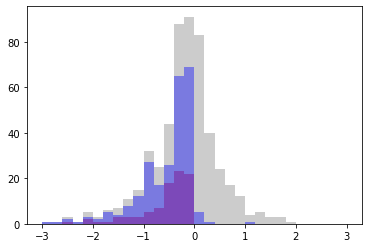

In [80]:
hist2, ax = plt.subplots()
ax.hist(all_amps*1e3, bins=bin_edges, color=(0.8, 0.8, 0.8))

ax.hist(ii_amps*1e3, bins=bin_edges, color='blue', alpha=0.4)
ax.hist(ie_amps*1e3, bins=bin_edges, color='purple', alpha=0.4)

In [64]:
fname = 'C:\\Users\\stephanies\\aisynphys\\analyses\\figures\\Fig3C_hist.svg'
hist2.savefig(fname)

In [66]:
pairs_has_rt = pairs[~pairs['psp_rise_time'].isnull()]
psp_rise = pairs_has_rt.groupby(['pre_class', 'post_class']).aggregate(lambda x: np.mean(x))
psp_rise.head()

id  experiment_id   pre_cell_id  post_cell_id  \
pre_class post_class                                                            
l23pyr    l23pyr      34180.000000     956.571429   5818.428571   5818.142857   
          l5et        76933.000000    2363.500000  13721.000000  13721.000000   
          pv          75682.923077    2329.076923  13478.384615  13476.846154   
          sst         80027.384615    2478.461538  14307.384615  14306.692308   
          vip         64858.555556    1941.444444  11398.555556  11398.222222   

                      has_synapse  has_electrical  crosstalk_artifact  \
pre_class post_class                                                    
l23pyr    l23pyr              1.0             0.0                 NaN   
          l5et                1.0             0.0                 NaN   
          pv                  1.0             0.0                 NaN   
          sst                 1.0             0.0                 NaN   
          vip                 1.0             0.0                 NaN   

                      n_ex_test_spikes  n_in_test_spikes  distance  meta  \
pre_class post_class                                                       
l23pyr    l23pyr            761.571429        327.000000  0.000075   NaN   
          l5et              430.500000        236.500000  0.000331   NaN   
          pv                845.461538        410.846154  0.000117   NaN   
          sst               587.923077        218.461538  0.000099   NaN   
          vip               672.333333        126.444444  0.000103   NaN   

                      psp_amplitude  psp_rise_time  psp_decay_tau   latency  
pre_class post_class                                                         
l23pyr    l23pyr           0.000185       0.004365       0.028934  0.001795  
          l5et            -0.000653       0.004768       0.009526  0.003594  
          pv               0.000318       0.002110       0.010108  0.001384  
          sst              0.000439       0.004543       0.044363  0.001491  
          vip              0.000576       0.005241       0.040284  0.001655

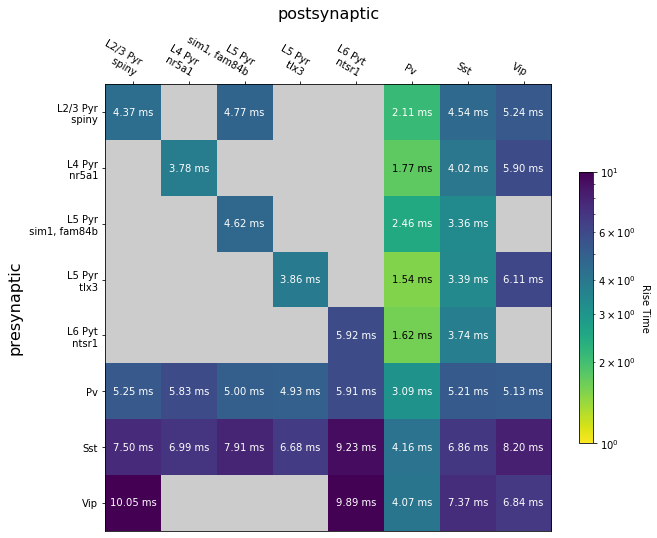

In [69]:
cmap = matplotlib.cm.get_cmap('viridis_r')
norm = matplotlib.colors.LogNorm(vmin=1, vmax=10, clip=False)

shape = (len(cell_classes), len(cell_classes))
data = np.zeros(shape)
data_alpha = np.zeros(shape)
data_str = np.zeros(shape, dtype=object)

for i, pre_class in enumerate(cell_classes):
    for j, post_class in enumerate(cell_classes):
        try:
            value = psp_rise.loc[pre_class].loc[post_class].psp_rise_time
        except KeyError:
            value = np.nan
        data[i, j] = value*1e3
        data_str[i, j] = "%0.2f ms" % (value*1e3) if np.isfinite(value) else ""
        data_alpha[i, j] = 1 if np.isfinite(value) else 0 
        
labels = [class_labels[cls] for cls in cell_classes]
mapper = matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm)
data_rgb = mapper.to_rgba(data)
data_rgb[:,:,3] = np.clip(data_alpha, 0, 1)

rise_time_fig, ax = plt.subplots(figsize=(10,10))
im, cbar = heatmap(data_rgb, labels, labels,
                  ax=ax,
                  ax_labels=('postsynaptic', 'presynaptic'),
                  bg_color=(0.8, 0.8, 0.8),
                  cmap=cmap,
                  norm=norm,
                  cbarlabel='Rise Time',
                  cbar_kw={'shrink':0.5})

text = annotate_heatmap(im, data_str, data=data)